# Process specifications

Dynamically adjusting parameters in a process to meet a specification is critical in designing a production process, and even more so when its under uncertaintly. BioSTEAM groups process specifications into two categories: analytical specifications, and numerical specifications. As the name suggests, an analytical specification is directly solved within a single loop of a system. A numerical specification, on the other hand, is solved numerically by rerunning a unit operation or even by reconverging a recycle system. The following real world examples will explain this in detail.

## Analytical specifications

### Denature ethanol fuel in a bioethanol process

Vary the amount of denaturant to add according to the flow of bioethanol. The final bioethanol product must be 2 wt. % denaturant:

In [1]:
from biosteam import settings, Chemical, Stream, units, main_flowsheet
import biosteam as bst; bst.nbtutorial()
# First name a new flowsheet
main_flowsheet.set_flowsheet('mix_ethanol_with_denaturant')

# Set the thermodynamic property package.
# In an actual process, much more chemicals
# would be defined, but here we keep it short.
settings.set_thermo(['Water', 'Ethanol', 'Octane'])

# Assume 40 million gal ethanol produced a year
# with 330 operating days
dehydrated_ethanol = Stream('dehydrated_ethanol', T=340,
                            Water=0.1, Ethanol=99.9, units='kg/hr')
operating_days_per_year = 330
dehydrated_ethanol.F_vol = 40e6 / operating_days_per_year
denaturant = Stream('denaturant', Octane=1)
M1 = units.Mixer('M1', ins=(dehydrated_ethanol, denaturant), outs='denatured_ethanol')

# Create the specification function.
@M1.add_specification(run=True) # Run mass and energy balance after specification function
def adjust_denaturant_flow():
    denaturant_over_ethanol_flow = 0.02 / 0.98 # A mass ratio
    denaturant.imass['Octane'] = denaturant_over_ethanol_flow * dehydrated_ethanol.F_mass
    
# Simulate, and check results. 
M1.simulate()
M1.show(composition=True, flow='kg/hr')

Mixer: M1
ins...
[0] dehydrated_ethanol  
    phase: 'l', T: 340 K, P: 101325 Pa
    composition (%): Water    0.1
                     Ethanol  99.9
                     -------  9.06e+07 kg/hr
[1] denaturant  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition (%): Octane  100
                     ------  1.85e+06 kg/hr
outs...
[0] denatured_ethanol  
    phase: 'l', T: 339.31 K, P: 101325 Pa
    composition (%): Water    0.098
                     Ethanol  97.9
                     Octane   2
                     -------  9.25e+07 kg/hr


All specifications are in the unit's specification list:

In [2]:
M1.specifications

[ProcessSpecification(f=adjust_denaturant_flow(), args=(), impacted_units=())]

We'll talk more about the `args` and `impacted_units` parameters in the next section on corn slurry. 

### Preparing corn slurry in a conventional dry-grind process

The solids content of a corn slurry fed to a conventional dry-grind corn ethanol plant is typically about 32 wt. %. Adjust the flow rate of water mixed with the milled corn such that the slurry is 32 wt. % solids:

In [3]:
# First name a new flowsheet
main_flowsheet.set_flowsheet('corn_slurry_example')

# Create a general chemicals to represent the 
# components of corn.
Starch = Chemical.blank('Starch', phase='s')
Fiber = Chemical.blank('Fiber', phase='s')
Oil = Chemical('Oil', search_ID='Oleic_acid')
Water = Chemical('Water')

# The exact properties are not important for 
# the example, so just assume its like water at
# 25 C and 1 atm.
Starch.default()
Fiber.default()

# Set the thermodynamic property package.
# In an actual process, much more chemicals
# would be defined, but here we keep it short.
settings.set_thermo([Starch, Oil, Fiber, Water])

# A typical dry grind process may produce
# 40 million gal of ethanol a year with a
# yield of 2.7 gal ethanol per bushel of corn.
corn_flow_per_year = 40e6 / 2.7 # In bushels
days_per_year = 365
operating_days_per_year = 330
corn_flow_per_day = corn_flow_per_year * days_per_year / operating_days_per_year

# The corn kernel iscomposed of starch (62%), protein and fiber (19%),
# water (15%), and oil (4%).
corn_feed = Stream('corn_feed',
    Starch=62, Fiber=19, Water=15, Oil=4,
    total_flow=corn_flow_per_day,
    units='bu/day', # bushel per day
)
T1 = bst.StorageTank('T1', corn_feed) 

# Water that will be mixed with the milled corn to create the slurry.
dilution_water = Stream('dilution_water', Water=1)
M1 = units.Mixer('M1', ins=(dilution_water, T1-0), outs='slurry')

@M1.add_specification(
    run=True, # Run mass and energy balance after specification function
    args=[0.32], # Arguments to pass to `adjust_water_flow`
) 
def adjust_water_flow(solids_content):
    F_mass_moisture = corn_feed.imass['Water']
    F_mass_solids = corn_feed.F_mass - F_mass_moisture
    water_solids_ratio = (1 - solids_content) / solids_content
    dilution_water.imass['Water'] = F_mass_solids * water_solids_ratio
    
# Simulate, and check results. 
corn_slurry_sys = main_flowsheet.create_system('corn_slurry_sys')
corn_slurry_sys.simulate()
M1.show(flow='kg/hr', composition=True)

Mixer: M1
ins...
[0] dilution_water  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition (%): Water  100
                     -----  4.33e+07 kg/hr
[1] s1  from  StorageTank-T1
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition (%): Starch  62.2
                     Oil     3.72
                     Fiber   19.1
                     Water   15
                     ------  2.4e+07 kg/hr
outs...
[0] slurry  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition (%): Starch  22.2
                     Oil     1.32
                     Fiber   6.79
                     Water   69.7
                     ------  6.73e+07 kg/hr


Let's say that the dilution water is first heated before mixing. This would affect upstream unit operations (e.g., the pump and the heat exchanger). We can make sure these unit operations are rerun after the specification function by passing the `impacted_units` argument with any unit operations that are directly impacted by the specification.

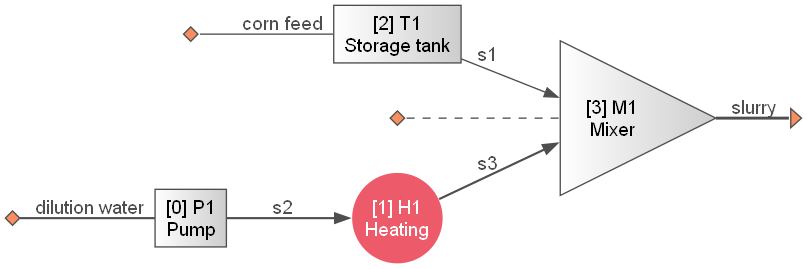

System: corn_slurry_sys
ins...
[0] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] dilution_water  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  2.4e+06
[2] corn_feed  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Starch  1.49e+07
                    Oil     3.15e+03
                    Fiber   4.57e+06
                    Water   2e+05
outs...
[0] slurry  
    phase: 'l', T: 331.77 K, P: 101325 Pa
    flow (kmol/hr): Starch  1.49e+07
                    Oil     3.15e+03
                    Fiber   4.57e+06
                    Water   2.6e+06


In [4]:
# Insert units
P1 = units.Pump('P1', dilution_water, P=5 * 101325)
H1 = units.HXutility('H1', P1-0, T=350)
M1.ins.append(H1-0)

M1.specifications.clear() # Remove specifications
# Create specification with impacted units.
M1.add_specification(
    adjust_water_flow, # Specification function
    args=[0.32], # Arguments passed to function.
    run=True, # Run mass and energy balance after specification function.
    impacted_units=[P1], # Dilution water is connected to P1.
    # BioSTEAM also takes into account units between the given impacted units
    # (P1) and the specification unit (M1). 
)

# Alternatively, you can add the impacted units to the original specification
# M1.specifications[0].impacted_units = [P1]

corn_slurry_sys = main_flowsheet.create_system('corn_slurry_sys')
dilution_water.empty() # Reset dilution water to very simulation
corn_slurry_sys.simulate()
corn_slurry_sys.diagram(format='png', kind='cluster', number=True)
corn_slurry_sys.show()

In [5]:
T1.show()

StorageTank: T1
ins...
[0] corn_feed  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Starch  1.49e+07
                    Oil     3.15e+03
                    Fiber   4.57e+06
                    Water   2e+05
outs...
[0] s1  to  Mixer-M1
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Starch  1.49e+07
                    Oil     3.15e+03
                    Fiber   4.57e+06
                    Water   2e+05


Notice how BioSTEAM forms a recycle loop between P1 and M1 to ensure convergence about the specification. The "tear" or recycle stream is s3 (the orange one).

Let's say we create the specification at the corn storage (T1) instead of at the slurry mixer (M1). Because P1 and H1 are in parallel (not upstream), you may expect an issue in the simulation order if P1 is run first than T1. However, by specifying `impacted_units`, BioSTEAM knows how to prioritize the simulation order.

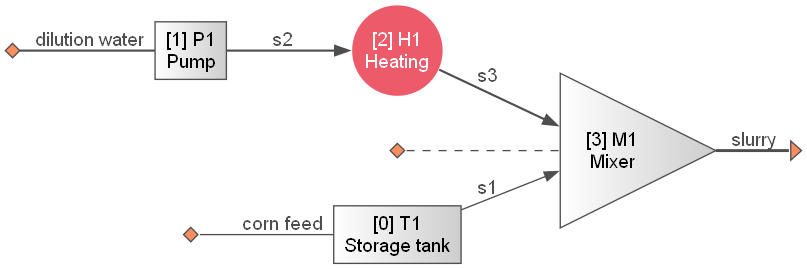

In [6]:
M1.specifications.clear() # Remove specifications
# Create specification with impacted units.
T1.add_specification(
    adjust_water_flow, # Specification function
    args=[0.32], # Arguments passed to function.
    run=True, # Run mass and energy balance after specification function.
    impacted_units=[P1], # Dilution water is connected to P1.
)

corn_slurry_sys = main_flowsheet.create_system('corn_slurry_sys')
corn_slurry_sys.simulate()
corn_slurry_sys.diagram(format='png', number=True)

In [7]:
corn_slurry_sys.show()

System: corn_slurry_sys
ins...
[0] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] dilution_water  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  2.4e+06
[2] corn_feed  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Starch  1.49e+07
                    Oil     3.15e+03
                    Fiber   4.57e+06
                    Water   2e+05
outs...
[0] slurry  
    phase: 'l', T: 331.77 K, P: 101325 Pa
    flow (kmol/hr): Starch  1.49e+07
                    Oil     3.15e+03
                    Fiber   4.57e+06
                    Water   2.6e+06


## Numerical specifications

### Flash design specification

Let's say we have a mixture of water, ethanol and propanol and we would like to evaporate 50% of the liquid by mass (not by mol). We can solve this problem numerically by testing whether the specification is met at a given temperature:

In [8]:
# First name a new flowsheet
main_flowsheet.set_flowsheet('flash_specification_example')

# Set the thermodynamic property package.
# In an actual process, much more chemicals
# would be defined, but here we keep it short.
settings.set_thermo(['Water', 'Ethanol', 'Propanol'])

# Feed stream
mixture = Stream('mixture', T=340,
                 Water=1000, Ethanol=1000, Propanol=1000,
                 units='kg/hr')

# Create a flash vessel
F1 = units.Flash('F1',
                 ins=mixture,
                 outs=('vapor', 'liquid'),
                 T=373, P=101325)

# Set a numerical specification which solves the objective function when called.
@F1.add_bounded_numerical_specification(x0=351.4, x1=373, xtol=1e-9, ytol=1e-3)
def f(x):
    # Objective function where f(x) = 0 at a 
    # vapor fraction of 50 wt. %.
    F1.T = x
    F1.run() # IMPORTANT: This runs the mass and energy balance at the new conditions
    feed = F1.ins[0]
    vapor = F1.outs[0]
    V = vapor.F_mass / feed.F_mass 
    return V - 0.5

# Now create the system, simulate, and check results. 
system = main_flowsheet.create_system()
system.simulate()
system.diagram()

In [9]:
print('vapor mass fraction: ', format(F1.outs[0].F_mass / mixture.F_mass, '.0%'))

vapor mass fraction:  50%
